## Buckshot++: An Outlier-Resistant and Scalable Clustering Algorithm. (Inspired by the [Buckshot Algorithm](https://pdfs.semanticscholar.org/1134/3448f8a817fa391e3a7897a95f975ad2873a.pdf).)

Here, we introduce a new algorithm, which we name Buckshot++. Buckshot++ improves upon the k-means by dealing with the main shortcoming thereof, namely, the need to predetermine the number of clusters, K. Typically, K is found in the following manner: 
1. settle on some metric,
2. evaluate that metric at multiple values of K, 
3. use a greedy stopping rule to determine when to stop (typically the bend in an elbow curve).

There must be a better way. We detail the following 3 improvements that the Buckshot++ algorithm makes to k-means.   
1. Not all metrics are create equal. And since **K-means doesn't prescribe which metric to use for finding K**, we analyzed that some of the commonly implemented metrics are too inconsistent from one iteration to the next. Buckshot++ prescribes the silhouette score for finding K.
2. **In k-means, every single point is clustered -- even the noise and outliers**. But what we really care about is the pattern and not the noise. We show here an elegant way to overcome this problem -- even simpler than [k-medoids](https://en.wikipedia.org/wiki/K-medoids) or [k-medians](https://en.wikipedia.org/wiki/K-medians_clustering). 
3. Finally, the [computational complexity](https://en.wikipedia.org/wiki/Computational_complexity) of running k-means multiple times on the whole dataset to find the best K can be prohibitive. We show below a surprisingly simple alternative with better asymptotics.

### Details of the Buckshot++ algorithm

**ALGORITHM**: Buckshot++ <br>
**INPUTS**: population of *N* vectors <br>
*B* := number of bootstrap samples <br>
*F* := max number of clusters to try <br>
*M* := cluster quality metric <br>
**OUTPUT**: the optimal *K* for kmeans

Take *B* bootstrap samples where each sample is of size 1/*B*.  
**for each** counter *k* from 2 to *F* **do** <br>
&emsp;&emsp;Compute kmeans with *k* centers. <br>
&emsp;&emsp;Compute the metric *M* on the clusters. <br>
Compute the centroid of all metrics vectors.  
Get argmax of the centroid vector.


### Explanation of Buckshot++
The Buckshot++ algorithm was motivated by the [Buckshot algorithm](https://pdfs.semanticscholar.org/1134/3448f8a817fa391e3a7897a95f975ad2873a.pdf), which essentially finds cluster centers by performing [hierarchical clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering) on a sample and then performing k-means by taking those cluster centers as inputs. [Hierarchical has relatively high time complexity](https://nlp.stanford.edu/IR-book/html/htmledition/time-complexity-of-hac-1.html), which is why Buckshot performs hierarchical only on a sample. The key difference between hierarchical and kmeans is that the former is more deterministic/stable but less scalable than the latter, as the next table elucidates.

In [6]:
%matplotlib inline
import pandas as pd
pd.set_option('display.max_rows', 500)
tbl = pd.DataFrame({'k-means': ['O(N * k * d * i)', 'random initial means; local minimum; outlier'],
                    'hierarchical': ['O(N^2 * logN)', 'outlier']}
                   , index=['Computational Complexity', 'Sources of Instability'])
tbl

k-means  \
Computational Complexity                              O(N * k * d * i)   
Sources of Instability    random initial means; local minimum; outlier   

                           hierarchical  
Computational Complexity  O(N^2 * logN)  
Sources of Instability          outlier

Hierarchical's higher time complexity means that, for large inputs, running k-means multiple times is still faster than running hierarchical just once. The Buckshot algorithm runs hierarchical just once on a small sample in order to initialize cluster centers for k-means. Since $O(N^2 * logN)$ grows really fast, the sample must be really small to make it work computationally. But a key critique of Buckshot is [failure to find the right structure with a small sample](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.136.7906&rep=rep1&type=pdf).  

Buckshot++'s key innovation lies in the step "Take B [bootstrap samples](http://www.stat.rutgers.edu/home/mxie/rcpapers/bootstrap.pdf) where each sample is of size 1/B." While Buckshot is doing hierarchical on a sample, Buckshot++ is doing multiple kmeans on *bootstrap* samples. Doing kmeans many times can still finish sooner than doing hierarchical just once, as the time complexities above show. An added bonus is that bootstrapping is a great way to smooth out noise and improve stability. In fact, that is exactly why **Bagging** (a.k.a. **B**ootstrap **Agg**regat**ing**) and [Random Forests](https://en.wikipedia.org/wiki/Random_forest#From_bagging_to_random_forests) work so well.

### Python implementation of Buckshot++
The core algorithm implementation is in the [buckshotpp module](https://github.com/zjohn77/buckshotpp/tree/master/buckshotpp). We use it below to cluster a news headlines dataset.

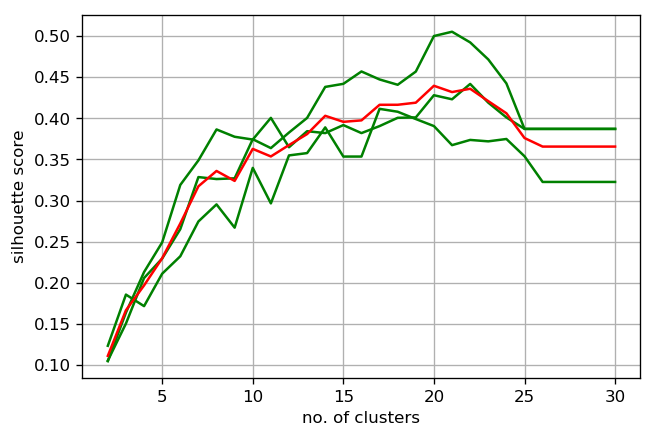

In [7]:
from buckshotpp import Clusterings, plot_mult_samples
from numpy.random import choice
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score
import nltk; nltk.download('punkt', quiet=True)
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 120
import warnings; warnings.filterwarnings('ignore')

vecSpaceMod = Clusterings({'file_loc': 'data/news_headlines.csv',
                           'tf_dampen': True,
                           'common_word_pct': 1,
                           'rare_word_pct': 1,
                           'dim_redu': False}
                         )  # Instantiate a Clusterings object using parameters.
news_df = vecSpaceMod.get_file() # Read news_headlines.csv into a df.
metrics_byK = vecSpaceMod.buckshot(news_df)
plot_mult_samples(metrics_byK, 'silhouette')

### An insight from this chart
Each green curve is generated from a bootstrap sample, and the red curve is their average. Remember the sources of instability for k-means listed in the table above? Outlier is one. The concept of outlier has somewhat different meaning in the context of clustering. In supervised learning, an outlier is a rare observation that's far from other observations distance-wise. In clustering, a far away observation is its own well-separated cluster. Here, our interpretation is that "rare" is the operative word here and that outliers are singleton clusters that exert undue influence on the formation of other clusters. Look at how **[bagging](https://en.wikipedia.org/wiki/Bootstrap_aggregating) led to a more stable estimate of the optimal number of clusters** in the graph above.

### Not all metrics are create equal
The two internal clustering metrics implemented in scikit-learn are: the Silhouette Coefficient and the [Calinski-Harabasz criterion](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabaz_score.html). Comparing the Silhouette plotted above with the Calinski plotted below, it's clear that Calinski is far more extreme, perhaps implausibly extreme.

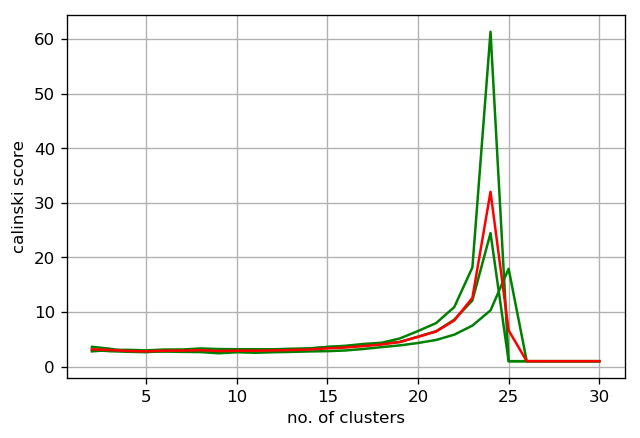

In [8]:
plot_mult_samples(metrics_byK, 'calinski')

### Internal or External Clustering Metrics?
This data contains a field named "STORY" that indicates which story a headline belongs to. With this field as the ground truth, we compute Mutual Information (the most common external metric) using the code below. Mutual Information's possible range is 0-1. Using the K resulting from Buckshot++, we obtained a Mutual Information of about 0.6, an indicator that the model performance is reasonable.

In [9]:
X = vecSpaceMod.term_weight_matr(news_df.TITLE)
kmeans_fit = KMeans(20).fit(X)  # the argument comes from inflectin point of silhouette plot
mutual_info = adjusted_mutual_info_score(labels_true=news_df.STORY, labels_pred=kmeans_fit.labels_) 
mutual_info

0.6435601965984835

### Practically, does Buckshot++ produce well-separated clusters?
Taking a look at the documents and their corresponding "predictedCluster", the results certainly do seem reasonable.

In [10]:
cluster_results = pd.DataFrame({'predictedCluster': kmeans_fit.labels_,
                                'document': news_df.TITLE})
cluster_results.sort_values(by='predictedCluster', inplace=True)

cluster_results

predictedCluster                                           document
25                 0                 SAC Capital Starts Anew as Point72
50                 0  Zebra Technologies to Acquire Enterprise Busin...
23                 0            Fine Tuning: Good Wife just gets better
21                 0  Boulder's Wealth May Be A Factor For Lowest Ob...
6                  0  Power restored to nuclear plant in Waterford, ...
73                 0      Electricity out as Millstone shifts to diesel
59                 1  Twitter's head of media Chloe Sladden steps do...
28                 1  Twitter's revolving door: media head Chloe Sla...
12                 1  Twitter Exec Exodus Continues with Media Chief...
67                 2  Sony Xperia C3 arrives with 5MP selfie camera,...
30                 2  Leaked: Images Of Sony's Xperia C3 'Selfie Phone'
45                 2  Sony Xperia Z2 Encased In A Block Of Ice, Cont...
90                 2  Sony Xperia Z4 Concept Emerges as Fan Imagines...
78                 2  If you hate the word 'selfie' look away now, t...
71                 3       Twitter Executive Quits Amid Stalling Growth
47                 3  Twitter COO quits, signalling management shake-up
52                 3                 Twitter Loses a Powerful Executive
31                 3  Second Twitter executive quits hours after Row...
20                 3                 Twitter COO resigns as growth lags
61                 3  Twitter COO Rowghani resigns amid lacklustre g...
57                 4  'Goodbye Twitter' COO Ali Rowghani, says bye t...
69                 4  Twitter chief operating officer resigns as use...
66                 4  UPDATE 3-Twitter chief operating officer resig...
86                 4  Twitter chief operating officer Ali Rowghani h...
76                 4  Ali Rowghani, Twitter's COO, resigns after mon...
49                 4  Twitter COO Ali Rowghani Just Announced Via Tw...
13                 4                     Twitter COO Ali Rowghani Exits
35                 4  Second Twitter exec resigns with goodbye tweet...
39                 5  Why almost everything you've been told about u...
77                 5               Why Fargo Works So Well as a TV Show
0                  6  'Mad Men' Preview: Buckle Up For 7 'Dense' Epi...
4                  6                  'Mad Men' end in sight for Weiner
36                 6  Weiner reflects on the beginning of the end of...
42                 7  Giant mystery crater in Siberia has scientists...
85                 7  Mysterious giant crater in the earth discovere...
60                 7               Massive Crater Discovered in Siberia
92                 7       Massive mystery crater at 'end of the world'
16                 7  Mysterious crater in Siberia spawns wild Inter...
43                 8         Inflation rise stalls wage hopes in the UK
82                 8                The Least Obese City in the Country
19                 8  Real wages could resume fall as "Easter effect...
55                 8  UK Inflation Rise To 1.8% Delays Real Wage Ris...
26                 8  Virginia's Governor Challenges Abortion Clinic...
51                 8  BREAKING NEWS: Transport costs lead to hike in...
8                  8  Cable prices climb 4 times faster than inflati...
79                 9  Despite Safety Issues, GM's Sales Still Increa...
17                 9  Chrysler Group LLC reports June 2014 US sales ...
40                 9   GM June Sales Up 9 Percent, Best June Since 2007
87                 9  Ford sales fall, GM barely even; Jeep powers C...
18                10          Gov. McAuliffe Makes Health Announcements
48                10  Microsoft wants Windows XP dead and has announ...
74                10             McAuliffe puts focus on women's health
7                 11  Sony makes duckfacing official with Xperia C3,...
54                11  Sony to announce 'Selfie' phone on July 8th wi...
27                11  Sony prepares to launc

### Summary of the key advantages of Buckshot++
* **Accurate** method of estimating the number of clusters (a clearly best Silhouette emerged every time, while typical elbow heuristic searches can hit or miss).
* **Scalable** (faster search for K achieved by using k-means rather than hierarchical; running k-means on subsample rather than everything).
* **Noise resistant** when used in conjunction with k-means++ (sampling with replacement lessens the chance of selecting an outlier in the bootstrap sample).